In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import time
from sklearn.linear_model import LinearRegression

def apply_lowpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'lowpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def apply_highpass_filter_1(data, high_freq, fs):
    filtered_data = np.zeros_like(data)
    b, a = signal.butter(1, high_freq / (0.5 * fs), 'highpass')
    zi = signal.lfilter_zi(b, a)
    filtered_data[:], _ = signal.lfilter(b, a, data[:], zi=zi*data[0])
    return filtered_data


def apply_bandpass_filter(data, low_freq, high_freq, fs):
    filtered_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        b, a = signal.butter(1, [low_freq / (0.5 * fs), high_freq / (0.5 * fs)], 'bandpass')
        zi = signal.lfilter_zi(b, a)
        filtered_data[:, i], _ = signal.lfilter(b, a, data[:, i], zi=zi*data[0, i])
    return filtered_data

def rescale_array(array1,array2):
    scaled_array=np.zeros_like(array1)
    for i in range(array1.shape[1]):
        new_min=np.min(array1[:,i])
        new_max=np.max(array1[:,i])
        min_val = np.min(array2[:,i])
        max_val = np.max(array2[:,i])
        scaled_array[:,i] = (array2[:,i] - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def rescale_array1(array1,array2):
    scaled_array=np.zeros_like(array1)
    new_min=np.min(array1)
    new_max=np.max(array1)
    min_val = np.min(array2)
    max_val = np.max(array2)
    scaled_array = (array2 - min_val) * (new_max - new_min) / (max_val - min_val) + new_min
    return scaled_array

def apply_lowpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time 

def apply_highpass_filter_realtime(data_point, b, a, zi):
    start_time = time.time()  # 记录开始时间
    filtered_data_point, zi = signal.lfilter(b, a, [data_point], zi=zi)
    end_time = time.time()  # 记录结束时间
    filter_time = end_time - start_time  # 计算滤波时间
    return filtered_data_point[0], zi, filter_time

class CustomLinearRegression:
    def __init__(self):
        self.slope = None
        self.intercept = None

    def fit(self, X, y):
        X = np.column_stack((np.arange(100).reshape(-1, 1), np.ones_like(np.arange(100).reshape(-1, 1)))) # Add column of ones for intercept
        self.coefficients = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.slope = self.coefficients[0]
        self.intercept = self.coefficients[1]

    def predict(self, X):
        return (X * self.slope + self.intercept).reshape(-1)
    

class LineIntersection:
    def __init__(self):
        pass
    
    def calculate_slope_intercept(self, point1, point2):
        # Calculate the slope and intercept of the line passing through two points
        x1, y1 = point1
        x2, y2 = point2
        
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        
        return slope, intercept
    
    def line_through_point_with_angle(self, position, yaw):
        # Given point
        x0 = position[0]
        y0 = position[1]
        
        # Convert yaw to radians
        yaw_rad = np.radians(yaw)
        
        # Calculate slope
        self.line2_slope = np.tan(yaw_rad + np.pi/2)  # Adding pi/2 because we want angle with x-axis
        self.line2_intercept = y0 - self.line2_slope * x0
    
    def intersection_point(self):
        # Solve the system of equations to find the intersection point
        x_intersect = (self.line2_intercept - self.line1_intercept) / (self.line1_slope - self.line2_slope)
        y_intersect = self.line1_slope * x_intersect + self.line1_intercept
        
        return x_intersect, y_intersect
    
    def distance_between_points(self, point1, point2):
        # Calculate the Euclidean distance between two points
        return np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)

    def calculate_GT(self, point1, point2, position, yaw):
        self.line1_slope, self.line1_intercept = self.calculate_slope_intercept(point1, point2)
        self.line_through_point_with_angle(position, yaw)
        intersection_point = self.intersection_point()
        distance = self.distance_between_points(position, intersection_point)
        GT = (distance - 0.016) * 1000
        return GT

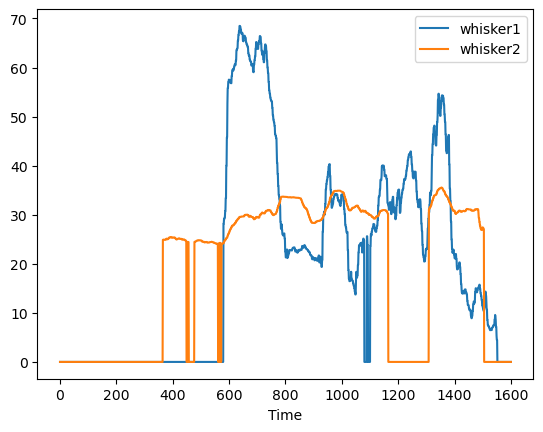

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# 读取CSV文件
data = pd.read_csv('whisker_data_MLP30-80_carbon_0.15ms.csv')

# 获取列数据并提取数字部分
whisker1 = data.iloc[:, 1].apply(lambda x: re.search(r'[-+]?\d*\.\d+|\d+', str(x)).group(0)).astype(float)
whisker2 = data.iloc[:, 2].apply(lambda x: re.search(r'[-+]?\d*\.\d+|\d+', str(x)).group(0)).astype(float)

# 绘制图表
plt.plot(whisker1, label="whisker1")
plt.plot(whisker2, label="whisker2")
plt.legend()
plt.xlabel("Time")
plt.show()

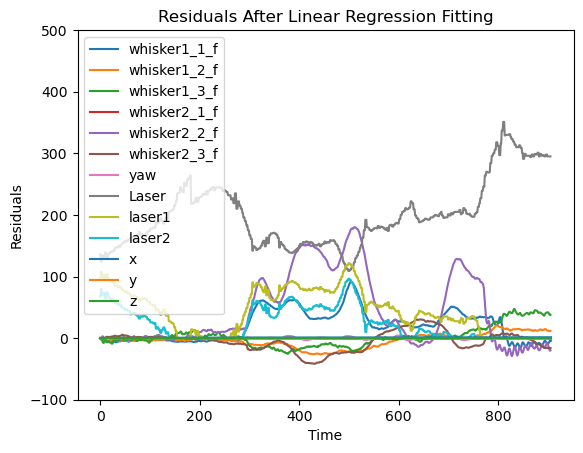

In [36]:
# 1-5
data = pd.read_csv('data/20240422/2024-04-30+15:58:23+.csv')
pressure = data.iloc[2:, 7:13].values
laser = data.iloc[2:, -1].values
yaw = data.iloc[2:, -3].values
position=data.iloc[2:,1:4].values
velocity=data.iloc[2:,4:7].values
laser1=laser+25*np.tan(np.radians(yaw-30))
laser2=laser-25*np.tan(np.radians(yaw-30))
laser1 = np.where(laser1 > 218, 0, 218 - laser1)
laser2 = np.where(laser2 > 218, 0, 218 - laser2)
pitch = data.iloc[2:, -2].values
point1 = [-0.255186, 1.189175]
point2 = [-1.104007, 1.177670]
line_intersection = LineIntersection()
GT = line_intersection.calculate_GT(point1, point2, [position[:,1],position[:,0]], yaw)
# GT=((1.188-position[:,0])/np.cos(np.radians(yaw))-0.016)*1000
GT1=GT+25*np.tan(np.radians(yaw))
GT2=GT-25*np.tan(np.radians(yaw))
GT1 = np.where(GT1 > 218, 0, 218 - GT1)
GT2 = np.where(GT2 > 218, 0, 218 - GT2)
# 时间步长
time_steps = np.arange(len(pressure))

# 创建线性回归模型
model = CustomLinearRegression()

# 初始化残差数组
residuals = np.zeros_like(pressure)

# 拟合前100个数据点的压力数据
for i in range(pressure.shape[1]):
    model.fit(time_steps[0:100], pressure[0:100, i])
    predicted_pressure = model.predict(time_steps)
    residuals[:, i] = pressure[:, i] - predicted_pressure

filtered_pressure = apply_bandpass_filter(residuals,0.05,1,50)


# plt.plot(residuals[:, 0] , label=f"whisker1_1")
# plt.plot(residuals[:, 1] , label=f"whisker1_2")
# plt.plot(residuals[:, 2] , label=f"whisker1_3")
# # plt.plot(residuals[:, 3] , label=f"whisker2_1")
# plt.plot(residuals[:, 4] , label=f"whisker2_2")
# plt.plot(residuals[:, 5] , label=f"whisker2_3")

plt.plot(filtered_pressure[:, 0] , label=f"whisker1_1_f")
plt.plot(filtered_pressure[:, 1] , label=f"whisker1_2_f")
plt.plot(filtered_pressure[:, 2] , label=f"whisker1_3_f")
plt.plot(filtered_pressure[:, 3] , label=f"whisker2_1_f")
plt.plot(filtered_pressure[:, 4] , label=f"whisker2_2_f")
plt.plot(filtered_pressure[:, 5] , label=f"whisker2_3_f")
# 绘制其他数据
# plt.plot(pitch, label="Pitch")
plt.plot(yaw, label="yaw")
plt.plot(laser, label="Laser")
# plt.plot(GT, label="GT")
# plt.plot(GT1, label="GT1")
# plt.plot(GT2, label="GT2")
plt.plot(laser1, label="laser1")
plt.plot(laser2, label="laser2")
plt.plot(position[:,0], label="x")
plt.plot(position[:,1], label="y")
plt.plot(position[:,2], label="z")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.ylim(-100, 500)
plt.title("Residuals After Linear Regression Fitting")
plt.show()


new_data = pd.DataFrame({
    'whisker1_1': filtered_pressure[:,0],
    'whisker1_2': filtered_pressure[:,1],
    'whisker1_3': filtered_pressure[:,2],
    'whisker2_1': filtered_pressure[:,3],
    'whisker2_2': filtered_pressure[:,4],
    'whisker2_3': filtered_pressure[:,5],
    'Laser1': laser1,
    'Laser2': laser2,
    'laser': laser,
    'yaw': yaw,
    'pitch': pitch,
    'positionX': position[:,0],
    'positionY': position[:,1],
    'positionZ': position[:,2],
    'velocityX': velocity[:,0],
    'velocityY': velocity[:,1],
    'velocityZ': velocity[:,2],
    'GT': GT,
    'GT1': GT1,
    'GT2': GT2

})
# new_data.to_csv('dataanalyse/0425/data1.csv', index=False)